# Assignment 5 Part-2

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
from sklearn.metrics import accuracy_score

from google.colab import drive


### Load Dataset usign torchvision image loader

In [0]:
drive.mount('/content/drive',force_remount=True)
# drive.mount("./gdrive")
# data_dir = '/content/drive/My Drive/MSDS/Semester 4/DL/Homeworks/Homework 5/Assignment 5 Dataset'

!unzip "/content/drive/My Drive/Assignment_05_Part_02_Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: A_05_Part_02_Dataset/Train/normal/52f18c9e-7262-4fcc-a6bc-78e707214886.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52f53bb5-81fb-408b-adc7-2f8ae8932b31.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52fee036-272a-455a-9714-b6ff73e28403.png  
  inflating: A_05_Part_02_Dataset/Train/normal/535c2337-e755-43ea-ab1d-6547a584776d.png  
  inflating: A_05_Part_02_Dataset/Train/normal/536ba3bf-b867-4035-b483-35e9cbda9c0f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/538d24ba-8a55-4445-b0d5-f9e5812fdd49.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bae9fc-3bb2-4684-b986-84bf7aa2e5a2.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bed796-1a7b-406b-b37c-d37facb41158.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c275e1-e692-4445-bb4f-b740d117712f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c369ae-d8f9-4e44-b212-c6e2dc6ef580.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53

In [0]:
data_dir = "A_05_Part_02_Dataset"
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
# train_target_transform = transforms.Compose([
#                                             transforms.Lambda(lambda x : [1,1,0] if x ==0 else ([0,1,0] if x ==1 else [0,0,1])),
#                                             transforms.ToTensor() 
#                                             ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

testset_data = datasets.ImageFolder(data_dir + '/TestData', transform=test_transforms)

#data loaders
train_batch_size, test_batch_size = 8, 8
trainloader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=True)
testsetloader = torch.utils.data.DataLoader(testset_data, batch_size=1, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


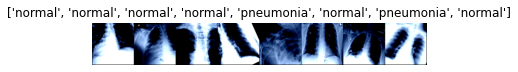

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

## VGG-16 without FL
#### FC = 3 (1024, 512,3)

### Load un-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=False)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


### Removing Last Layer

In [0]:
num_features = vgg16.classifier[0].in_features # 0 means input we are receiving from VGG Conv features
# putting array value 0 instead of -1 (which is used to neglect last layer) to add new layers
features = list(vgg16.classifier.children())[:0] # Remove all FC layer
print(num_features)

25088


### Freezing the layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

for i in range(0,31): # Unfreezing all CNN Layer
  vgg16.features[i].requires_grad = True



### Adding New Layer

In [0]:
roll_number_neurons = 4*10+100
features.extend([
                 nn.Linear(num_features, roll_number_neurons)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(roll_number_neurons, 2) #using 2 before currently data loaded isn't of binary class
                 ])

In [0]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loading Pretrained Model

In [0]:
# First I prepared the model created by PhDEE19004 and then loaded it's params
PATH = "vgg16_entire_RN4_97.pth" # loaded a good more epochs trained model
vgg16.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Modify FC layer


In [0]:
num_features = vgg16.classifier[0].in_features # 0 means input we are receiving from VGG Conv features

features = list(vgg16.classifier.children())[:0] # Remove all FC layer

features.extend([nn.Linear(num_features, 1024)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(1024, 512)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(512, 3) #using 3 before currently data loaded isn't of binary class
                 ])

vgg16.classifier = nn.Sequential(*features)
for i in range(0,31): # Unfreezing all CNN Layer
  vgg16.features[i].requires_grad = True

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### One Hot Converter

In [0]:

def OneHot(targets, device):
  new_targets=[]
  with torch.no_grad():
    for i,target in enumerate(targets):
      if target.item()==0:
        new_targets.append([1,1,0])
      elif target.item()==1:
        new_targets.append([0,1,0])
      elif target.item() ==2:
        new_targets.append([0,0,1])
  return torch.tensor(new_targets,dtype=float, device=device)

### Loss fucntion and optimizer

In [0]:
Epochs = 5
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9)

### Training

In [0]:
since = time.time()
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16.to(device)

# vgg16.train()
loss_plot = []
loss_plot_val = []
accuracy_plot = []
accuracy_plot_val=[]

for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    running_corrects = 0
    epoch_loss=0.0
    epoch_acc=0
    pbar = tqdm(enumerate(trainloader))
    print(pbar)
    for i, data in pbar:
        # if i==1:
        #   break
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        
        outputs = torch.sigmoid(outputs)
        preds = torch.where(outputs >= 0.5, torch.tensor(1,device=device), torch.tensor(0,device=device))
        labels = OneHot(labels, device)
        # print(preds)
        # print(labels)
        loss = criterion(outputs, labels)   #----> compute loss
        
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()

        running_corrects += precision_score(labels.data.cpu(),preds.cpu(),average='micro')
        train_data_len = len(trainloader.dataset)
        epoch_loss = running_loss / train_data_len
        epoch_acc = running_corrects / (train_data_len/train_batch_size)
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tTraining Loss: {:.4f}  Training Acc: {:.4f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                epoch_loss, epoch_acc))   

    loss_plot.append(epoch_loss)
    
    accuracy_plot.append(epoch_acc)
    correct = 0
    total = 0
    with torch.no_grad():
        running_loss_val = 0.0
        running_corrects_val=0.0
        for data in tqdm(testloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)               #----> forward pass
            
            
            outputs = torch.sigmoid(outputs)
            preds = torch.where(outputs >= 0.5, torch.tensor(1,device=device), torch.tensor(0,device=device))
            labels = OneHot(labels, device)
            
            loss_val = criterion(outputs, labels)
            
            running_loss_val += loss_val.item()

            running_corrects_val += precision_score(labels.data.cpu(),preds.cpu(),average='micro')


        test_data_len = len(testloader.dataset)
        epoch_loss = running_loss_val / test_data_len
        epoch_acc = running_corrects_val / (test_data_len/test_batch_size)

        loss_plot_val.append(epoch_loss)
        accuracy_plot_val.append(epoch_acc)
    
    time_elapsed = time.time() - since
        # print(loss)
    torch.save(vgg16.state_dict(), 'vgg_without_focal_loss.pth')

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))












































































0it [00:00, ?it/s]

cuda:0
0it [00:00, ?it/s]


Streaming output truncated to the last 5000 lines.
















































 18%|█▊        | 14/79 [00:02<00:12,  5.19it/s]










































































 19%|█▉        | 15/79 [00:02<00:12,  5.18it/s]










































































 20%|██        | 16/79 [00:03<00:12,  5.25it/s]










































































 22%|██▏       | 17/79 [00:03<00:12,  4.98it/s]










































































 23%|██▎       | 18/79 [00:03<00:11,  5.17it/s]










































































 24%|██▍       | 19/79 [00:03<00:11,  5.16it/s]










































































 25%|██▌       | 20/79 [00:03<00:11,  5.16it/s]










































































 27%|██▋       | 21/79 [00:04<00:11,  5.04it/s]

0it [00:00, ?it/s]


Streaming output truncated to the last 5000 lines.
















































 18%|█▊        | 14/79 [00:02<00:12,  5.17it/s]










































































 19%|█▉        | 15/79 [00:02<00:12,  5.23it/s]










































































 20%|██        | 16/79 [00:03<00:11,  5.26it/s]










































































 22%|██▏       | 17/79 [00:03<00:15,  4.13it/s]










































































 23%|██▎       | 18/79 [00:03<00:13,  4.38it/s]










































































 24%|██▍       | 19/79 [00:03<00:12,  4.70it/s]










































































 25%|██▌       | 20/79 [00:04<00:12,  4.85it/s]










































































 27%|██▋       | 21/79 [00:04<00:11,  4.92it/s]

0it [00:00, ?it/s]


Streaming output truncated to the last 5000 lines.
















































 18%|█▊        | 14/79 [00:02<00:12,  5.14it/s]










































































 19%|█▉        | 15/79 [00:03<00:12,  5.08it/s]










































































 20%|██        | 16/79 [00:03<00:12,  5.02it/s]










































































 22%|██▏       | 17/79 [00:03<00:12,  5.08it/s]










































































 23%|██▎       | 18/79 [00:03<00:11,  5.11it/s]










































































 24%|██▍       | 19/79 [00:03<00:11,  5.16it/s]










































































 25%|██▌       | 20/79 [00:04<00:11,  5.18it/s]










































































 27%|██▋       | 21/79 [00:04<00:11,  5.18it/s]

0it [00:00, ?it/s]


Streaming output truncated to the last 5000 lines.
















































 18%|█▊        | 14/79 [00:03<00:14,  4.52it/s]










































































 19%|█▉        | 15/79 [00:03<00:13,  4.61it/s]










































































 20%|██        | 16/79 [00:03<00:13,  4.65it/s]










































































 22%|██▏       | 17/79 [00:03<00:12,  4.80it/s]










































































 23%|██▎       | 18/79 [00:03<00:12,  4.91it/s]










































































 24%|██▍       | 19/79 [00:04<00:12,  4.98it/s]










































































 25%|██▌       | 20/79 [00:04<00:11,  4.95it/s]










































































 27%|██▋       | 21/79 [00:04<00:11,  5.03it/s]

0it [00:00, ?it/s]


Streaming output truncated to the last 5000 lines.
















































 18%|█▊        | 14/79 [00:02<00:14,  4.57it/s]










































































 19%|█▉        | 15/79 [00:02<00:12,  4.93it/s]










































































 20%|██        | 16/79 [00:03<00:12,  5.03it/s]










































































 22%|██▏       | 17/79 [00:03<00:12,  5.07it/s]










































































 23%|██▎       | 18/79 [00:03<00:11,  5.12it/s]










































































 24%|██▍       | 19/79 [00:03<00:11,  5.13it/s]










































































 25%|██▌       | 20/79 [00:03<00:11,  5.19it/s]










































































 27%|██▋       | 21/79 [00:04<00:11,  5.25it/s]

0it [00:00, ?it/s]


Streaming output truncated to the last 5000 lines.
















































 18%|█▊        | 14/79 [00:02<00:14,  4.34it/s]










































































 19%|█▉        | 15/79 [00:03<00:13,  4.60it/s]










































































 20%|██        | 16/79 [00:03<00:13,  4.78it/s]










































































 22%|██▏       | 17/79 [00:03<00:12,  4.92it/s]










































































 23%|██▎       | 18/79 [00:03<00:12,  5.08it/s]










































































 24%|██▍       | 19/79 [00:03<00:11,  5.12it/s]










































































 25%|██▌       | 20/79 [00:04<00:17,  3.46it/s]










































































 27%|██▋       | 21/79 [00:04<00:14,  3.87it/s]

0it [00:00, ?it/s]


Streaming output truncated to the last 5000 lines.
















































 16%|█▋        | 13/79 [00:02<00:13,  5.04it/s]










































































 18%|█▊        | 14/79 [00:03<00:12,  5.14it/s]










































































 19%|█▉        | 15/79 [00:03<00:12,  5.16it/s]










































































 20%|██        | 16/79 [00:03<00:12,  4.94it/s]










































































 22%|██▏       | 17/79 [00:03<00:12,  4.86it/s]










































































 23%|██▎       | 18/79 [00:03<00:12,  5.02it/s]










































































 24%|██▍       | 19/79 [00:04<00:11,  5.13it/s]










































































 25%|██▌       | 20/79 [00:04<00:15,  3.82it/s]

0it [00:00, ?it/s]


Streaming output truncated to the last 5000 lines.
















































 15%|█▌        | 12/79 [00:02<00:12,  5.38it/s]










































































 16%|█▋        | 13/79 [00:02<00:11,  5.61it/s]










































































 18%|█▊        | 14/79 [00:02<00:11,  5.50it/s]










































































 19%|█▉        | 15/79 [00:02<00:11,  5.49it/s]










































































 20%|██        | 16/79 [00:02<00:11,  5.49it/s]










































































 22%|██▏       | 17/79 [00:03<00:12,  5.08it/s]










































































 23%|██▎       | 18/79 [00:03<00:11,  5.18it/s]










































































 24%|██▍       | 19/79 [00:03<00:11,  5.10it/s]



Training complete in 25m 30s


### Plot Loss & Accuracies

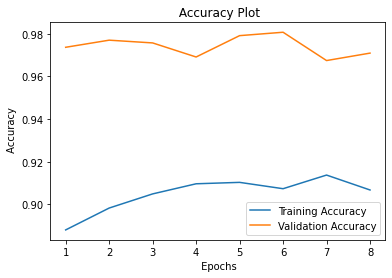

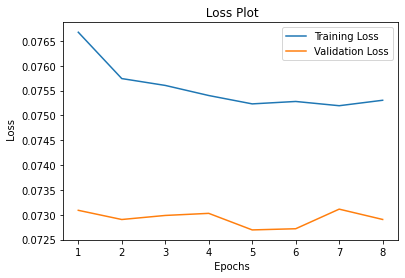

In [0]:

plt.title(" Accuracy Plot")
plt.xlabel(" Epochs")
plt.ylabel(" Accuracy")
plt.xticks(np.arange(1, Epochs+1, 1.0))
plt.plot(range(1,Epochs+1),accuracy_plot,label="Training Accuracy")
plt.plot(range(1,Epochs+1),accuracy_plot_val,label="Validation Accuracy")
plt.legend()
plt.show()

plt.title(" Loss Plot")
plt.xlabel(" Epochs")
plt.ylabel(" Loss")
plt.xticks(np.arange(1, Epochs+1, 1.0))
plt.plot(range(1,Epochs+1),loss_plot,label="Training Loss")
plt.plot(range(1,Epochs+1),loss_plot_val,label="Validation Loss")
plt.legend()
plt.show()


### Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix, f1_score
number_of_classes = 3
confusion_matrix = torch.zeros(number_of_classes, number_of_classes)
with torch.no_grad():
    for i, (inputs, label) in enumerate(testloader):
        inputs = inputs.to(device)
        label = label.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[  0.,  22.,   6.],
        [  0., 398.,   2.],
        [  0.,  19., 181.]])


### F1 Score

In [0]:
f1_batch=0
for i,(inputs,label) in enumerate(testloader):
        inputs = inputs.to(device)
        label = label.to(device)
        # compute output
        output = vgg16(inputs)
        # loss = criterion(output,label)
        _, preds = torch.max(output, 1)
        # losses.update(loss.item(),input.size(0))
        f1_batch += f1_score(label.cpu(),preds.cpu() > 0.15,average='micro')
f1_batch=f1_batch/i
print('F1 Score: ',f1_batch)

F1 Score:  0.6474358974358975


### Final Accuracy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


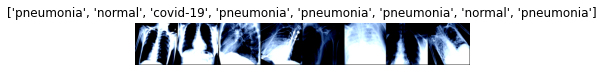

In [0]:
dataiter = iter(trainloader) # converted it to train because test batch is of 1500 (converted to increase speed)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal pneumonia normal pneumonia normal pneumonia
Ground Truth:  pneumonia normal covid-19 pneumonia pneumonia pneumonia normal pneumonia


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Final Accuracy of the network on the ',len(testloader.dataset),' test images: %d %%' % (
    100 * correct / total))

Final Accuracy of the network on the  628  test images: 92 %


## ResNet without FL
#### FC = 3 (1024, 512,3)

### Load pre-trained ResNet


In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=False)
print(resnet18)
print('Output Layer of ResNet18 : ', resnet18.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
print(resnet18.fc)

Linear(in_features=512, out_features=1000, bias=True)


### Removing Last Layer

In [0]:
num_features = resnet18.fc.in_features # 0 means input we are receiving from VGG Conv features
# putting array value 0 instead of -1 (which is used to neglect last layer) to add new layers
features = list(resnet18.fc.children())[:0] # Remove all FC layer
print(num_features)

512


### Freezing the layers

In [0]:
# Freeze training for all layers
for param in resnet18.parameters():
    param.requires_grad = True

# for i in range(0,31): # Unfreezing all CNN Layer
#   resnet18.features[i].requires_grad = True



### Adding New Layer

In [0]:
roll_number_neurons = 52*10+100
features.extend([
                 nn.Linear(num_features, roll_number_neurons)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(roll_number_neurons, 2) #using 2 before currently data loaded isn't of binary class
                 ])

In [0]:
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# First I prepared the model created by MSDS18052 and then loaded it's params
PATH = "res18_entire_RN52_96.pth" # loaded a good more epochs trained model
resnet18.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Modify FC layer


In [0]:
# num_features = resnet18.fc.in_features # 0 means input we are receiving from VGG Conv features

features = list(resnet18.fc.children())[:0] # Remove all FC layer

features.extend([nn.Linear(num_features, 256)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(256, 128)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(128, 3) #using 3 before currently data loaded isn't of binary class
                 ])

resnet18.fc = nn.Sequential(*features)
for param in resnet18.parameters(): # Unfreezing all CNN Layer
  resnet18.requires_grad = True

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### One Hot Converter

In [0]:

def OneHot(targets, device):
  new_targets=[]
  with torch.no_grad():
    for i,target in enumerate(targets):
      if target.item()==0:
        new_targets.append([1,1,0])
      elif target.item()==1:
        new_targets.append([0,1,0])
      elif target.item() ==2:
        new_targets.append([0,0,1])
  return torch.tensor(new_targets,dtype=float, device=device)

### Loss fucntion and optimizer

In [0]:
Epochs = 5
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

### Training

In [0]:
from tqdm import tqdm
since = time.time()
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet18.to(device)

# resnet18.train()
loss_plot = []
loss_plot_val = []
accuracy_plot = []
accuracy_plot_val=[]

for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    running_corrects = 0
    epoch_loss=0.0
    epoch_acc=0
    pbar = tqdm(enumerate(trainloader), position=0, leave=True)
    for i, data in pbar:
        # if i==1:
        #   break
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        
        outputs = torch.sigmoid(outputs)
        preds = torch.where(outputs >= 0.5, torch.tensor(1,device=device), torch.tensor(0,device=device))
        labels = OneHot(labels, device)
        # print(preds)
        # print(labels)
        loss = criterion(outputs, labels)   #----> compute loss
        
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()

        running_corrects += accuracy_score(labels.data.cpu(),preds.cpu())
        train_data_len = len(trainloader.dataset)
        epoch_loss = running_loss / train_data_len
        epoch_acc = running_corrects / (train_data_len/train_batch_size)
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tTraining Loss: {:.4f}  Training Acc: {:.4f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),100. * i / len(trainloader),epoch_loss, epoch_acc))   

    loss_plot.append(epoch_loss)
    
    accuracy_plot.append(epoch_acc)
    correct = 0
    total = 0
    with torch.no_grad():
        running_loss_val = 0.0
        running_corrects_val=0.0
        for data in tqdm(testloader, position=0, leave=True):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)               #----> forward pass
            
            
            outputs = torch.sigmoid(outputs)
            preds = torch.where(outputs >= 0.5, torch.tensor(1,device=device), torch.tensor(0,device=device))
            labels = OneHot(labels, device)
            
            loss_val = criterion(outputs, labels)
            
            running_loss_val += loss_val.item()

            running_corrects_val += accuracy_score(labels.data.cpu(),preds.cpu())


        test_data_len = len(testloader.dataset)
        epoch_loss = running_loss_val / test_data_len
        epoch_acc = running_corrects_val / (test_data_len/test_batch_size)

        loss_plot_val.append(epoch_loss)
        accuracy_plot_val.append(epoch_acc)
    
    time_elapsed = time.time() - since
        # print(loss)
    torch.save(resnet18.state_dict(), 'resnet18_without_focal_loss.pth')

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

0it [00:00, ?it/s]

cuda:0


Train Epoch: 0 [6192/6200 (100%)]	Training Loss: 0.0743  Training Acc: 0.8747: : 775it [02:39,  5.24it/s]
































































































































































































































































































































































































































































































































































































































































































































































































































































































































 99%|█████████▊| 78/79 [00:14<00:00,  5.95it/s]


























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































Train Epoch: 1 [6192/6200 (100%)]	Training Loss: 0.0742  Training Acc: 0.8766: : 775it [02:37,  5.40it/s]
































































































































































































































































































































































































































































































































































































































































































































































































































































































































 99%|█████████▊| 78/79 [00:13<00:00,  5.60it/s]


























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































Train Epoch: 2 [6192/6200 (100%)]	Training Loss: 0.0740  Training Acc: 0.8826: : 775it [02:37,  5.12it/s]
































































































































































































































































































































































































































































































































































































































































































































































































































































































































 99%|█████████▊| 78/79 [00:13<00:00,  4.64it/s]


























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































Train Epoch: 3 [6192/6200 (100%)]	Training Loss: 0.0741  Training Acc: 0.8813: : 775it [02:35,  4.75it/s]
































































































































































































































































































































































































































































































































































































































































































































































































































































































































 99%|█████████▊| 78/79 [00:13<00:00,  6.03it/s]


























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































Train Epoch: 4 [6192/6200 (100%)]	Training Loss: 0.0743  Training Acc: 0.8721: : 775it [02:35,  4.75it/s]
































































































































































































































































































































































































































































































































































































































































































































































































































































































































 99%|█████████▊| 78/79 [00:13<00:00,  6.30it/s]




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































Training complete in 14m 18s


### Plot Loss & Accuracies

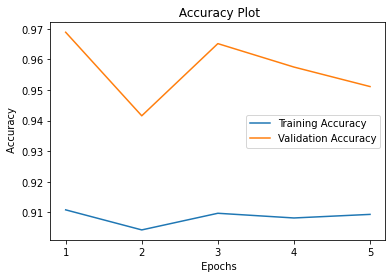

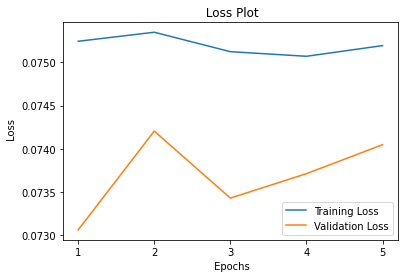

In [0]:

plt.title(" Accuracy Plot")
plt.xlabel(" Epochs")
plt.ylabel(" Accuracy")
plt.xticks(np.arange(1, Epochs+1, 1.0))
plt.plot(range(1,Epochs+1),accuracy_plot,label="Training Accuracy")
plt.plot(range(1,Epochs+1),accuracy_plot_val,label="Validation Accuracy")
plt.legend()
plt.show()

plt.title(" Loss Plot")
plt.xlabel(" Epochs")
plt.ylabel(" Loss")
plt.xticks(np.arange(1, Epochs+1, 1.0))
plt.plot(range(1,Epochs+1),loss_plot,label="Training Loss")
plt.plot(range(1,Epochs+1),loss_plot_val,label="Validation Loss")
plt.legend()
plt.show()


### Confusion Matrix

In [0]:
from sklearn.metrics import  f1_score
number_of_classes = 3
confusion_matrix = torch.zeros(number_of_classes, number_of_classes)
with torch.no_grad():
    for i, (inputs, label) in enumerate(testloader):
        inputs = inputs.to(device)
        label = label.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[  2.,  19.,   7.],
        [  1., 392.,   7.],
        [  1.,  16., 183.]])


### F1 Score

In [0]:
f1_batch=0
for i,(inputs,label) in enumerate(testloader):
        inputs = inputs.to(device)
        label = label.to(device)
        # compute output
        output = resnet18(inputs)
        # loss = criterion(output,label)
        _, preds = torch.max(output, 1)
        # losses.update(loss.item(),input.size(0))
        f1_batch += f1_score(label.cpu(),preds.cpu() > 0.15,average='micro')
f1_batch=f1_batch/i
print('F1 Score: ',f1_batch)

F1 Score:  0.6538461538461539


### Final Accuracy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


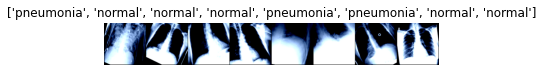

In [0]:
dataiter = iter(trainloader) # converted it to train because test batch is of 1500 (converted to increase speed)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  pneumonia normal normal normal pneumonia pneumonia normal normal
Ground Truth:  pneumonia normal normal normal pneumonia pneumonia normal normal


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Final Accuracy of the network on the ',len(testloader.dataset),' test images: %d %%' % (
    100 * correct / total))

Final Accuracy of the network on the  628  test images: 92 %


## VGG-16 with FL
#### FC = 3 (1024, 512,3)

### Load un-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=False)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


### Removing Last Layer

In [0]:
num_features = vgg16.classifier[0].in_features # 0 means input we are receiving from VGG Conv features
# putting array value 0 instead of -1 (which is used to neglect last layer) to add new layers
features = list(vgg16.classifier.children())[:0] # Remove all FC layer
print(num_features)

25088


### Freezing the layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

for i in range(0,31): # Unfreezing all CNN Layer
  vgg16.features[i].requires_grad = True



### Adding New Layer

In [0]:
roll_number_neurons = 4*10+100
features.extend([
                 nn.Linear(num_features, roll_number_neurons)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(roll_number_neurons, 2) #using 2 before currently data loaded isn't of binary class
                 ])

In [0]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loading Pretrained Model

In [0]:
# First I prepared the model created by PhDEE19004 and then loaded it's params
PATH = "vgg16_entire_RN4_97.pth" # loaded a good more epochs trained model
vgg16.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Modify FC layer


In [0]:
num_features = vgg16.classifier[0].in_features # 0 means input we are receiving from VGG Conv features

features = list(vgg16.classifier.children())[:0] # Remove all FC layer

features.extend([nn.Linear(num_features, 1024)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(1024, 512)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(512, 3) #using 3 before currently data loaded isn't of binary class
                 ])

vgg16.classifier = nn.Sequential(*features)
for i in range(0,31): # Unfreezing all CNN Layer
  vgg16.features[i].requires_grad = True

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### One Hot Converter

In [0]:

def OneHot(targets, device):
  new_targets=[]
  with torch.no_grad():
    for i,target in enumerate(targets):
      if target.item()==0:
        new_targets.append([1,1,0])
      elif target.item()==1:
        new_targets.append([0,1,0])
      elif target.item() ==2:
        new_targets.append([0,0,1])
  return torch.tensor(new_targets, device=device)

### Define Focal Loss

In [0]:
import torch.nn.functional as F
def FocalLoss(preds, labels,alpha=1, gamma=2, logits=False):

        BCE_loss = F.binary_cross_entropy(preds.double(), labels.double())
        pt = torch.exp(-BCE_loss)
        F_loss = alpha * (1-pt)**gamma * BCE_loss
        return torch.mean(F_loss)

### Loss fucntion and optimizer

In [0]:
Epochs = 8
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9)

### Training

In [0]:
from tqdm import tqdm
since = time.time()
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16.to(device)

# vgg16.train()
loss_plot = []
loss_plot_val = []
accuracy_plot = []
accuracy_plot_val=[]

for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    running_corrects = 0
    epoch_loss=0.0
    epoch_acc=0
    pbar = tqdm(enumerate(trainloader), position=0, leave=True)
    print(pbar)
    for i, data in pbar:
        # if i==1:
        #   break
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        
        outputs = torch.sigmoid(outputs)
        preds = torch.where(outputs >= 0.5, torch.tensor(1,device=device), torch.tensor(0,device=device))
        labels = OneHot(labels, device)
        # print(preds)
        # print(labels)
        loss = FocalLoss(outputs, labels)   #----> compute loss
        
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()

        running_corrects += accuracy_score(labels.data.cpu(),preds.cpu())
        train_data_len = len(trainloader.dataset)
        epoch_loss = running_loss / train_data_len
        epoch_acc = running_corrects / (train_data_len/train_batch_size)
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tTraining Loss: {:.4f}  Training Acc: {:.4f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                epoch_loss, epoch_acc))   

    loss_plot.append(epoch_loss)
    
    accuracy_plot.append(epoch_acc)
    correct = 0
    total = 0
    with torch.no_grad():
        running_loss_val = 0.0
        running_corrects_val=0.0
        for data in tqdm(testloader, position=0, leave=True):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)               #----> forward pass
            
            
            outputs = torch.sigmoid(outputs)
            preds = torch.where(outputs >= 0.5, torch.tensor(1,device=device), torch.tensor(0,device=device))
            labels = OneHot(labels, device)
            


            loss_val = FocalLoss(outputs, labels)

            running_loss_val += loss_val.item()

            running_corrects_val += accuracy_score(labels.data.cpu(),preds.cpu())


        test_data_len = len(testloader.dataset)
        epoch_loss = running_loss_val / test_data_len
        epoch_acc = running_corrects_val / (test_data_len/test_batch_size)

        loss_plot_val.append(epoch_loss)
        accuracy_plot_val.append(epoch_acc)
    
    time_elapsed = time.time() - since
        # print(loss)
    torch.save(vgg16.state_dict(), 'vgg_without_focal_loss.pth')

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

0it [00:00, ?it/s]

cuda:0
0it [00:00, ?it/s]


Train Epoch: 0 [6192/6200 (100%)]	Training Loss: 0.0038  Training Acc: 0.7919: : 775it [02:47,  4.89it/s]
































































































































































































































































































































































































































































































































































































































































































































































































































































































































 99%|█████████▊| 78/79 [00:15<00:00,  4.28it/s]


























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 1 [6192/6200 (100%)]	Training Loss: 0.0027  Training Acc: 0.8416: : 775it [02:45,  4.96it/s]
































































































































































































































































































































































































































































































































































































































































































































































































































































































































 99%|█████████▊| 78/79 [00:15<00:00,  4.90it/s]


























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 2 [6192/6200 (100%)]	Training Loss: 0.0023  Training Acc: 0.8479: : 775it [02:43,  5.02it/s]
































































































































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 79/79 [00:15<00:00,  6.14it/s]


























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 3 [6192/6200 (100%)]	Training Loss: 0.0023  Training Acc: 0.8524: : 775it [02:43,  4.38it/s]
































































































































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 79/79 [00:15<00:00,  5.34it/s]


























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 4 [6192/6200 (100%)]	Training Loss: 0.0021  Training Acc: 0.8490: : 775it [02:41,  4.97it/s]
































































































































































































































































































































































































































































































































































































































































































































































































































































































































 99%|█████████▊| 78/79 [00:15<00:00,  5.33it/s]


























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 5 [6192/6200 (100%)]	Training Loss: 0.0022  Training Acc: 0.8571: : 775it [02:41,  5.10it/s]
































































































































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 79/79 [00:15<00:00,  5.53it/s]






































































































































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 79/79 [00:15<00:00,  5.08it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 6 [6192/6200 (100%)]	Training Loss: 0.0021  Training Acc: 0.8598: : 775it [02:43,  5.03it/s]




























































































































































































































































































































































































































































































































































































































































































































































































































































































Train Epoch: 6 [6192/6200 (100%)]	

100%|██████████| 79/79 [00:15<00:00,  6.41it/s]



















































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 79/79 [00:15<00:00,  5.06it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 7 [6192/6200 (100%)]	Training Loss: 0.0019  Training Acc: 0.8648: : 775it [02:43,  4.77it/s]











































































































































































































































































































































































































































































































































































































































































































































































































Train Epoch: 7 [6192/6200 (100%)]	Training Loss: 0.0019  Training Acc: 0.8648: : 775it [02:43,  4.73it/s]
  0%|    

 99%|█████████▊| 78/79 [00:15<00:00,  5.10it/s]




































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 79/79 [00:15<00:00,  5.09it/s]




Training complete in 24m 0s


### Plot Loss & Accuracies

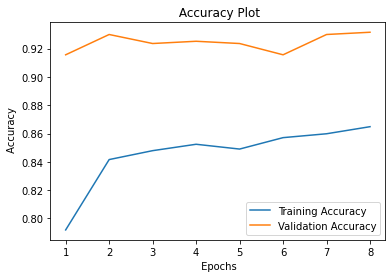

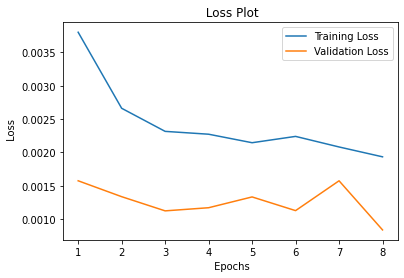

In [0]:

plt.title(" Accuracy Plot")
plt.xlabel(" Epochs")
plt.ylabel(" Accuracy")
plt.xticks(np.arange(1, Epochs+1, 1.0))
plt.plot(range(1,Epochs+1),accuracy_plot,label="Training Accuracy")
plt.plot(range(1,Epochs+1),accuracy_plot_val,label="Validation Accuracy")
plt.legend()
plt.show()

plt.title(" Loss Plot")
plt.xlabel(" Epochs")
plt.ylabel(" Loss")
plt.xticks(np.arange(1, Epochs+1, 1.0))
plt.plot(range(1,Epochs+1),loss_plot,label="Training Loss")
plt.plot(range(1,Epochs+1),loss_plot_val,label="Validation Loss")
plt.legend()
plt.show()


### Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix, f1_score
number_of_classes = 3
confusion_matrix = torch.zeros(number_of_classes, number_of_classes)
with torch.no_grad():
    for i, (inputs, label) in enumerate(testloader):
        inputs = inputs.to(device)
        label = label.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[  0.,  22.,   6.],
        [  0., 397.,   3.],
        [  0.,  18., 182.]])


### F1 Score

In [0]:
for i,(inputs,label) in enumerate(testloader):
        inputs = inputs.to(device)
        label = label.to(device)
        # compute output
        output = vgg16(inputs)
        # loss = criterion(output,label)
        _, preds = torch.max(output, 1)
        # losses.update(loss.item(),input.size(0))
        f1_batch += f1_score(label.cpu(),preds.cpu() > 0.15,average='micro')
f1_batch=f1_batch/i
print('F1 Score: ',f1_batch)

F1 Score:  0.6525312294543064


### Final Accurcy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


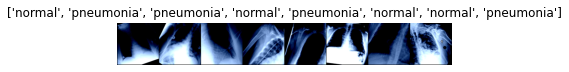

In [0]:
dataiter = iter(trainloader) # converted it to train because test batch is of 1500 (converted to increase speed)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal pneumonia pneumonia normal normal normal normal pneumonia
Ground Truth:  normal pneumonia pneumonia normal pneumonia normal normal pneumonia


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Final Accuracy of the network on the ',len(testloader.dataset),' test images: %d %%' % (
    100 * correct / total))

Final Accuracy of the network on the  628  test images: 92 %


## ResNet with FL
#### FC = 3 (1024, 512,3)

### Load pre-trained ResNet


In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=False)
print(resnet18)
print('Output Layer of ResNet18 : ', resnet18.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
print(resnet18.fc)

Linear(in_features=512, out_features=1000, bias=True)


### Removing Last Layer

In [0]:
num_features = resnet18.fc.in_features # 0 means input we are receiving from VGG Conv features
# putting array value 0 instead of -1 (which is used to neglect last layer) to add new layers
features = list(resnet18.fc.children())[:0] # Remove all FC layer
print(num_features)

512


### Freezing the layers

In [0]:
# Freeze training for all layers
for param in resnet18.parameters():
    param.requires_grad = True

# for i in range(0,31): # Unfreezing all CNN Layer
#   resnet18.features[i].requires_grad = True



### Adding New Layer

In [0]:
roll_number_neurons = 52*10+100
features.extend([
                 nn.Linear(num_features, roll_number_neurons)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(roll_number_neurons, 2) #using 2 before currently data loaded isn't of binary class
                 ])

In [0]:
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loading Pretrained Model

In [0]:
# First I prepared the model created by MSDS18052 and then loaded it's params
PATH = "res18_entire_RN52_96.pth" # loaded a good more epochs trained model
resnet18.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Modify FC layer


In [0]:
# num_features = resnet18.fc.in_features # 0 means input we are receiving from VGG Conv features

features = list(resnet18.fc.children())[:0] # Remove all FC layer

features.extend([nn.Linear(num_features, 256)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(256, 128)
                 ,nn.ReLU(inplace=True)
                 ,nn.Dropout(p=0.5, inplace=False)
                 ,nn.Linear(128, 3) #using 3 before currently data loaded isn't of binary class
                 ])

resnet18.fc = nn.Sequential(*features)
for param in resnet18.parameters(): # Unfreezing all CNN Layer
  resnet18.requires_grad = True

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### One Hot Converter

In [0]:

def OneHot(targets, device):
  new_targets=[]
  with torch.no_grad():
    for i,target in enumerate(targets):
      if target.item()==0:
        new_targets.append([1,1,0])
      elif target.item()==1:
        new_targets.append([0,1,0])
      elif target.item() ==2:
        new_targets.append([0,0,1])
  return torch.tensor(new_targets, device=device)

### Define Focal Loss

In [0]:
import torch.nn.functional as F
def FocalLoss(preds, labels,alpha=1, gamma=2, logits=False):

        BCE_loss = F.binary_cross_entropy(preds.double(), labels.double())
        pt = torch.exp(-BCE_loss)
        F_loss = alpha * (1-pt)**gamma * BCE_loss
        return torch.mean(F_loss)

### Loss fucntion and optimizer

In [0]:
Epochs = 8
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.005, momentum=0.9)

### Training

In [0]:
from tqdm import tqdm
since = time.time()
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet18.to(device)

# resnet18.train()
loss_plot = []
loss_plot_val = []
accuracy_plot = []
accuracy_plot_val=[]

for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    running_corrects = 0
    epoch_loss=0.0
    epoch_acc=0
    pbar = tqdm(enumerate(trainloader), position=0, leave=True)
    print(pbar)
    for i, data in pbar:
        # if i==1:
        #   break
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        
        outputs = torch.sigmoid(outputs)
        preds = torch.where(outputs >= 0.5, torch.tensor(1,device=device), torch.tensor(0,device=device))
        labels = OneHot(labels, device)
        # print(preds)
        # print(labels)
        loss = FocalLoss(outputs, labels)   #----> compute loss
        
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()

        running_corrects += accuracy_score(labels.data.cpu(),preds.cpu())
        train_data_len = len(trainloader.dataset)
        epoch_loss = running_loss / train_data_len
        epoch_acc = running_corrects / (train_data_len/train_batch_size)
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tTraining Loss: {:.4f}  Training Acc: {:.4f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                epoch_loss, epoch_acc))   

    loss_plot.append(epoch_loss)
    
    accuracy_plot.append(epoch_acc)
    correct = 0
    total = 0
    with torch.no_grad():
        running_loss_val = 0.0
        running_corrects_val=0.0
        for data in tqdm(testloader, position=0, leave=True):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)               #----> forward pass
            
            
            outputs = torch.sigmoid(outputs)
            preds = torch.where(outputs >= 0.5, torch.tensor(1,device=device), torch.tensor(0,device=device))
            labels = OneHot(labels, device)
            


            loss_val = FocalLoss(outputs, labels)

            running_loss_val += loss_val.item()

            running_corrects_val += accuracy_score(labels.data.cpu(),preds.cpu())


        test_data_len = len(testloader.dataset)
        epoch_loss = running_loss_val / test_data_len
        epoch_acc = running_corrects_val / (test_data_len/test_batch_size)

        loss_plot_val.append(epoch_loss)
        accuracy_plot_val.append(epoch_acc)
    
    time_elapsed = time.time() - since
        # print(loss)
    torch.save(resnet18.state_dict(), 'resnet18_with_focal_loss.pth')

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

0it [00:00, ?it/s]

cuda:0
0it [00:00, ?it/s]


Train Epoch: 0 [6192/6200 (100%)]	Training Loss: 0.0047  Training Acc: 0.7589: : 775it [02:42,  5.06it/s]






























































































































































































































































































































































































































































































































































































































































































































Train Epoch: 0 [6192/6200 (100%)]	Training Loss: 0.0047  Training Acc: 0.7589: : 775it [02:43,  4.75it/s]
  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:14<00:00,  4.99it/s]

























































































































































































































































































































































































































































































































































































































































































100%|██████████| 79/79 [00:14<00:00,  5.42it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 1 [6192/6200 (100%)]	Training Loss: 0.0030  Training Acc: 0.8377: : 775it [02:45,  5.11it/s]





















































































































































































































































































































































































































































































































































































































































Train Epoch: 1 [6192/6200 (100%)]	Training Loss: 0.0030  Training Acc: 0.8377: : 775it [02:45,  4.69it/s]
  0%|          | 0/79 [00:00<?, ?it/s]

 99%|█████████▊| 78/79 [00:14<00:00,  6.14it/s]


















































































































































































































































































































































































































































































































































































































100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 2 [6192/6200 (100%)]	Training Loss: 0.0030  Training Acc: 0.8355: : 775it [02:45,  4.92it/s]
















































































































































































































































































































































































































































































































































































Train Epoch: 2 [6192/6200 (100%)]	Training Loss: 0.0030  Training Acc: 0.8355: : 775it [02:45,  4.68it/s]
  0%|          | 0/79 [00:00<?, ?it/s]

 99%|█████████▊| 78/79 [00:14<00:00,  5.57it/s]















































































































































































































































































































































































































































































































































100%|██████████| 79/79 [00:15<00:00,  5.26it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 3 [6192/6200 (100%)]	Training Loss: 0.0026  Training Acc: 0.8521: : 775it [02:45,  4.04it/s]















































































































































































































































































































































































































































































































Train Epoch: 3 [6192/6200 (100%)]	Training Loss: 0.0026  Training Acc: 0.8521: : 775it [02:45,  4.69it/s]
  0%|          | 0/79 [00:00<?, ?it/s]

 99%|█████████▊| 78/79 [00:14<00:00,  3.62it/s]
















































































































































































































































































































































































































































































100%|██████████| 79/79 [00:14<00:00,  5.35it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 4 [6192/6200 (100%)]	Training Loss: 0.0024  Training Acc: 0.8582: : 775it [02:44,  4.82it/s]


















































































































































































































































































































































































































































Train Epoch: 4 [6192/6200 (100%)]	Training Loss: 0.0024  Training Acc: 0.8582: : 775it [02:44,  4.70it/s]
  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:14<00:00,  5.50it/s]





















































































































































































































































































































































































































100%|██████████| 79/79 [00:14<00:00,  5.38it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 5 [6192/6200 (100%)]	Training Loss: 0.0025  Training Acc: 0.8577: : 775it [02:43,  4.95it/s]

























































































































































































































































































































































































Train Epoch: 5 [6192/6200 (100%)]	Training Loss: 0.0025  Training Acc: 0.8577: : 775it [02:43,  4.74it/s]
  0%|          | 0/79 [00:00<?, ?it/s]

 99%|█████████▊| 78/79 [00:14<00:00,  5.63it/s]






























































































































































































































































































































































100%|██████████| 79/79 [00:14<00:00,  5.41it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 6 [6192/6200 (100%)]	Training Loss: 0.0022  Training Acc: 0.8626: : 775it [02:43,  4.88it/s]




































































































































































































































































































































Train Epoch: 6 [6192/6200 (100%)]	Training Loss: 0.0022  Training Acc: 0.8626: : 775it [02:43,  4.73it/s]
  0%|          | 0/79 [00:00<?, ?it/s]

 99%|█████████▊| 78/79 [00:14<00:00,  6.01it/s]











































































































































































































































































































100%|██████████| 79/79 [00:14<00:00,  5.46it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


Train Epoch: 7 [6192/6200 (100%)]	Training Loss: 0.0023  Training Acc: 0.8637: : 775it [02:42,  5.10it/s]



















































































































































































































































































Train Epoch: 7 [6192/6200 (100%)]	Training Loss: 0.0023  Training Acc: 0.8637: : 775it [02:42,  4.77it/s]
  0%|          | 0/79 [00:00<?, ?it/s]

 99%|█████████▊| 78/79 [00:14<00:00,  6.04it/s]




























































































































































































































































100%|██████████| 79/79 [00:14<00:00,  5.46it/s]




Training complete in 23m 52s


### Plot Loss & Accuracies

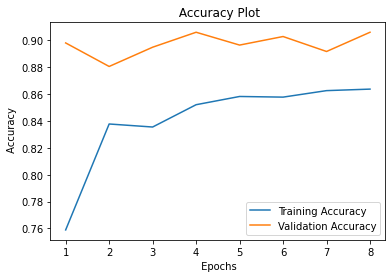

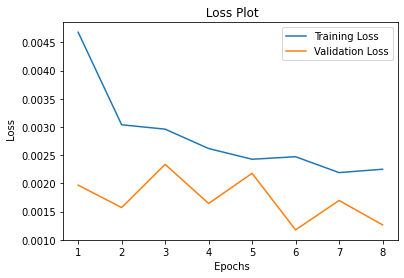

In [0]:

plt.title(" Accuracy Plot")
plt.xlabel(" Epochs")
plt.ylabel(" Accuracy")
plt.xticks(np.arange(1, Epochs+1, 1.0))
plt.plot(range(1,Epochs+1),accuracy_plot,label="Training Accuracy")
plt.plot(range(1,Epochs+1),accuracy_plot_val,label="Validation Accuracy")
plt.legend()
plt.show()

plt.title(" Loss Plot")
plt.xlabel(" Epochs")
plt.ylabel(" Loss")
plt.xticks(np.arange(1, Epochs+1, 1.0))
plt.plot(range(1,Epochs+1),loss_plot,label="Training Loss")
plt.plot(range(1,Epochs+1),loss_plot_val,label="Validation Loss")
plt.legend()
plt.show()


### Confusion Matrix

In [0]:
from sklearn.metrics import  f1_score
number_of_classes = 3
confusion_matrix = torch.zeros(number_of_classes, number_of_classes)
with torch.no_grad():
    for i, (inputs, label) in enumerate(testloader):
        inputs = inputs.to(device)
        label = label.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[  0.,  24.,   4.],
        [  0., 392.,   8.],
        [  0.,  20., 180.]])


### F1 Score

In [0]:
f1_batch=0
for i,(inputs,label) in enumerate(testloader):
        inputs = inputs.to(device)
        label = label.to(device)
        # compute output
        output = resnet18(inputs)
        # loss = criterion(output,label)
        _, preds = torch.max(output, 1)
        # losses.update(loss.item(),input.size(0))
        f1_batch += f1_score(label.cpu(),preds.cpu() > 0.15,average='micro')
f1_batch=f1_batch/i
print('F1 Score: ',f1_batch)

F1 Score:  0.6458333333333334


### Final Accuracy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


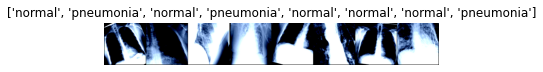

In [0]:
dataiter = iter(trainloader) # converted it to train because test batch is of 1500 (converted to increase speed)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal pneumonia normal pneumonia normal normal normal pneumonia
Ground Truth:  normal pneumonia normal pneumonia normal normal normal pneumonia


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Final Accuracy of the network on the ',len(testloader.dataset),' test images: %d %%' % (
    100 * correct / total))

Final Accuracy of the network on the  628  test images: 90 %


# Generate CSV

In [0]:
f = open("test_labels.csv", "w")
with torch.no_grad():
    for i, data in tqdm(enumerate(testsetloader), position=0, leave=True):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        sample_fname  = testsetloader.dataset.samples[i]
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        # outputs = torch.sigmoid(outputs)
        # preds = torch.where(outputs >= 0.5, torch.tensor(1,device=device), torch.tensor(0,device=device))
        f.write("{}, {}\n".format(sample_fname, preds.item()))

629it [00:16, 40.38it/s]












































629it [00:16, 37.82it/s]